# Pixel induced current
In this notebook we load a track dataset and we calculate the current induced on the pixels placed at the anode.

In [34]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [35]:
from larndsim import consts, quenching, drifting, detsim
import importlib
importlib.reload(drifting)
importlib.reload(quenching)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

import pickle
import numpy as np
import numba as nb
import pandas as pd
import time

Here we load the dataset with the tracks and we store the column cols corresponding to the each variable.

In [36]:
tracks_dict = pickle.load(open('edepsimDataset.p', 'rb'))
tracks = pd.DataFrame.from_dict(tracks_dict)
tracks['t'] = 0.
tracks['t_start'] = 0.
tracks['t_end'] = 0.
tracks['x_start'] = tracks_dict['z_start'] 
tracks['z_start'] = tracks_dict['x_start'] 
tracks['x_end'] = tracks_dict['z_end'] 
tracks['z_end'] = tracks_dict['x_end'] 

tracks['z_start'] /= 1e2
tracks['z_end'] /= 1e2
tracks['y_start'] /= 1e2
tracks['y_end'] /= 1e2
tracks['x_start'] /= 1e2
tracks['x_end'] /= 1e2

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0.
tracks['longDiff'] = 0.
tracks['tranDiff'] = 0.

tracks_np = tracks.to_numpy()
cols = nb.typed.Dict()
for i, c, in enumerate(tracks.columns):
    cols[c] = i

quenching.Quench(tracks_np, cols, mode="box")
drifting.Drift(tracks_np, cols)

In [37]:
n_pixels = 333
x_pixel_size = (consts.tpc_borders[0][1] - consts.tpc_borders[0][0]) / n_pixels
y_pixel_size = (consts.tpc_borders[1][1] - consts.tpc_borders[1][0]) / n_pixels
pixel_size = (x_pixel_size, y_pixel_size)

## Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [38]:
selected_tracks = tracks_np[:100]
pixelTrackIDs = detsim.pixelID_track(selected_tracks, cols, (x_pixel_size, y_pixel_size))
pIDs_array = detsim.list2array(pixelTrackIDs)

t_sampling = 1
slice_size = 20
anode_t = np.linspace(consts.timeInterval[0], 
                      consts.timeInterval[1], 
                      int(round(consts.timeInterval[1]-consts.timeInterval[0])/t_sampling))

In [41]:
importlib.reload(detsim)


<module 'larndsim.detsim' from '/global/u1/s/soleti/larnd-sim/larndsim/detsim.py'>

In [42]:
active_pixels = detsim.tracks_current(selected_tracks, pIDs_array, cols, pixel_size, t_sampling, slice_size)

/global/u1/s/soleti/larnd-sim/larndsim/detsim.py:363: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tracks_current" failed type inference due to: Invalid use of type(CPUDispatcher(<function track_current at 0x2aab8a2cbb00>)) with parameters (array(float64, 1d, A), array(int64, 2d, C), DictType[unicode_type,int64], int64, int64, DictType[UniTuple(int64 x 2),ListType[Tuple(float64, float64, array(float64, 1d, C))]], UniTuple(float64 x 2))

During: resolving callee type: type(CPUDispatcher(<function track_current at 0x2aab8a2cbb00>))
During: typing of call at /global/u1/s/soleti/larnd-sim/larndsim/detsim.py (385)


File "../larndsim/detsim.py", line 385:
def track_current(track, pixels, cols, slice_size, t_sampling, active_pixels, pixel_size, time_padding=20.0):
    <source elided>
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        pixel_signal[threadsperblock,blockspergrid](signals, 
        ^

  break
/global/u1/s/so

In [43]:
currents = np.array([sum(detsim.pixel_response(active_pixels[p], anode_t)) for p in active_pixels.keys()])

## Track and pixel display
Here we show the selected tracks and the pixels affected by them. The color of the pixel correspond to the integrated induced current.

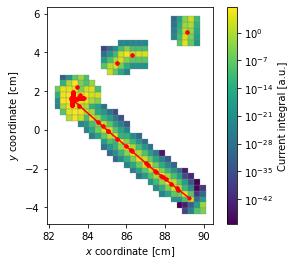

In [44]:
norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1)
for i,p in enumerate(active_pixels.keys()):
    if currents[i]:
        rect = plt.Rectangle((p[0]*x_pixel_size+consts.tpc_borders[0][0],
                              p[1]*y_pixel_size+consts.tpc_borders[1][0]),
                             x_pixel_size,y_pixel_size,
                             linewidth=0.3,
                             edgecolor='grey', 
                             facecolor=m.to_rgba(currents[i]), label='Pixel')
        ax.add_patch(rect)
    
for t in selected_tracks:
    ax.plot((t[cols['x_start']], t[cols['x_end']]), 
            (t[cols['y_start']], t[cols['y_end']]),
            c='r',
            zorder=10)
    ax.scatter((t[cols['x_start']], t[cols['x_end']]), 
               (t[cols['y_start']], t[cols['y_end']]),
               c='r',
               s=10,
               zorder=10)

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_aspect("equal")
_ = plt.colorbar(m,fraction=0.046, pad=0.04, label='Current integral [a.u.]')


(-7.0, 7.0)

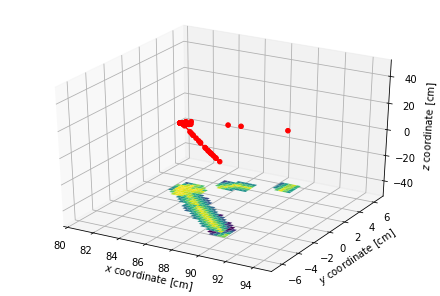

In [45]:
%matplotlib inline
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)


for i,p in enumerate(list(active_pixels.keys())):
    rect = plt.Rectangle((p[0]*x_pixel_size+consts.tpc_borders[0][0],
                          p[1]*y_pixel_size+consts.tpc_borders[1][0]),
                         x_pixel_size,y_pixel_size,
                         linewidth=0,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(currents[i]), label='Pixel')
    ax.add_patch(rect)
    art3d.pathpatch_2d_to_3d(rect, z=-50, zdir="z")
    
for t in selected_tracks:
    ax.plot((t[cols['x_start']], t[cols['x_end']]), 
            (t[cols['y_start']], t[cols['y_end']]),
            (t[cols['z_start']], t[cols['z_end']]),
            c='r',
            zorder=99999)
    ax.scatter((t[cols['x_start']], t[cols['x_end']]), 
               (t[cols['y_start']], t[cols['y_end']]),
               (t[cols['z_start']], t[cols['z_end']]),
               c='r')

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_zlabel("$z$ coordinate [cm]")
ax.set_zlim3d(-50,50)
ax.set_xlim3d(80,95)
ax.set_ylim3d(-7,7)

Text(0, 0.5, 'Current [a.u.]')

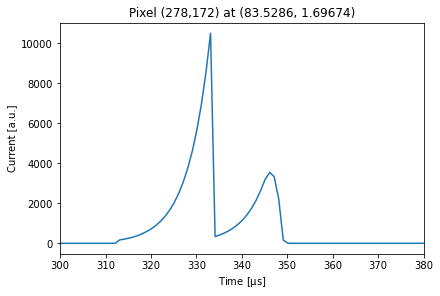

In [46]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
pixelID = detsim.pixel_from_coordinates(83.55,1.8,n_pixels)
current = detsim.pixel_response(active_pixels[pixelID], anode_t)
ax.plot(anode_t, current, label='Current')
ax.set_xlim(300,380)  
ax.set_title("Pixel (%i,%i) at (%g, %g)" % (pixelID[0], pixelID[1], 
                                      (pixelID[0] + x_pixel_size/2)*x_pixel_size+consts.tpc_borders[0][0], 
                                      (pixelID[1] + y_pixel_size/2)*y_pixel_size+consts.tpc_borders[1][0]))
ax.set_xlabel("Time [$\mathrm{\mu}$s]")
ax.set_ylabel("Current [a.u.]")